# Data Analysis

First we need to import our packages and our merged csv!

In [1]:
!pip install statsmodels
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
df_mtn_death = pd.read_csv('df_mtn_death')


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


# Visualization

Now we are going to create a Data visualization that shows the amount of deaths per mountain height. We will sort it in ascending order to better show the distribution of deaths by height.

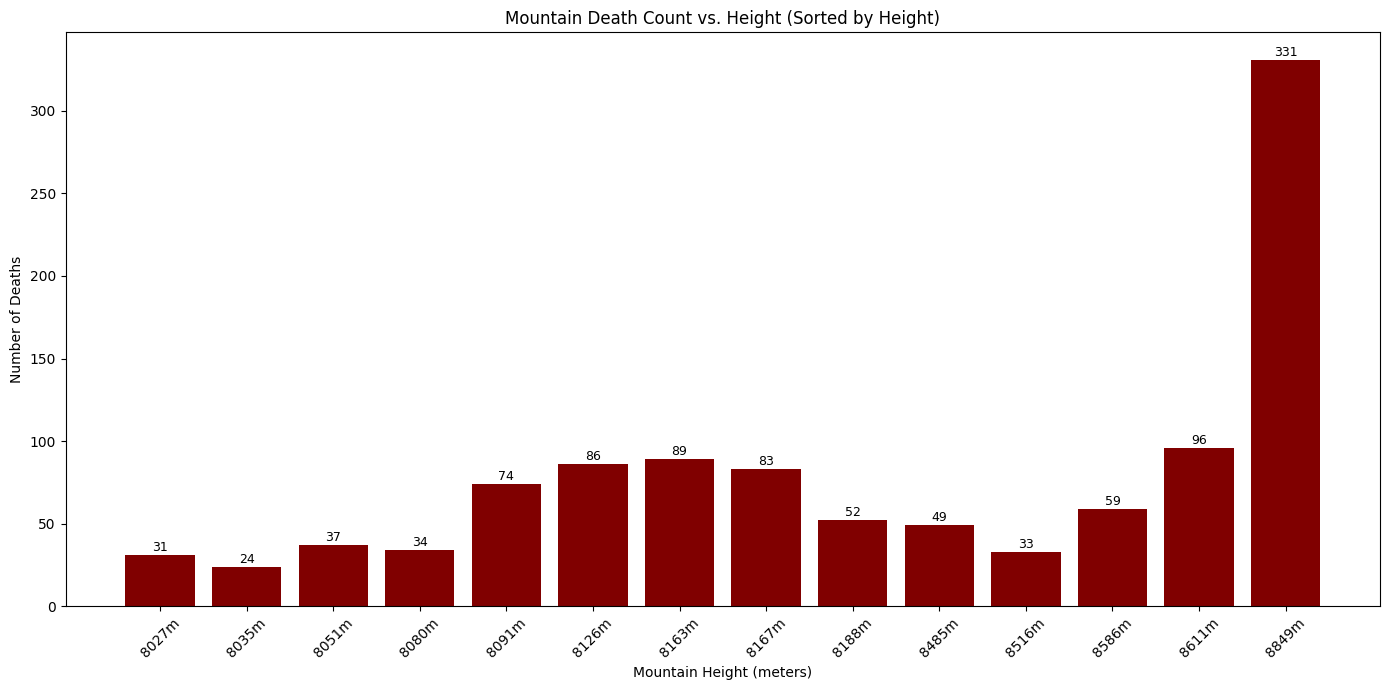

In [2]:
# Count deaths per mountain
death_counts = df_mtn_death['Mountain'].value_counts().reset_index()
death_counts.columns = ['Mountain', 'Death Count']

# Add height
heights = (
    df_mtn_death[['Mountain', 'Height(rounded)[dp 2]']]
    .drop_duplicates()
)

# Clean the height column
heights['Height'] = heights['Height(rounded)[dp 2]'].str.replace(',', '').astype(int)

# Merge height into the death count table
death_counts = death_counts.merge(heights[['Mountain', 'Height']], on='Mountain', how='left')

# Sort by height
death_counts = death_counts.sort_values('Height', ascending=True)

# Create a label column that shows both height and for reference
death_counts['Height_Label'] = death_counts['Height'].astype(str) + 'm'

# Option 1: Bar chart with height on x-axis, death count on y-axis
plt.figure(figsize=(14, 7))
bars = plt.bar(death_counts['Height_Label'], death_counts['Death Count'], color='maroon')

plt.xlabel('Mountain Height (meters)')
plt.ylabel('Number of Deaths')
plt.title('Mountain Death Count vs. Height (Sorted by Height)')

for i, death_count in enumerate(death_counts['Death Count']):
    plt.text(i, death_count + 0.5, f'{death_count}', 
             ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We were curious and therefore created a second visualization comparing the causes of deaths associated with mountain heights. We wanted a more basic visualization, however, so we sorted the mountains into two groups: "Above Median Height" and "Below Median Height". These results are actually quite interesting and logically make a lot of sense (i.e. climbers of taller mountains being more likely to die from "altitude illness".

The "Cause of Death" column was very descriptive and tailored to each case so we had to clean it up by sorting them into larger categories.

/tmp/ipykernel_936/1316119755.py:33: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:maroon'` for the same effect.

  sns.countplot(data=df_mtn_death, x='Cause_simple', hue='Height Category', color = 'maroon')


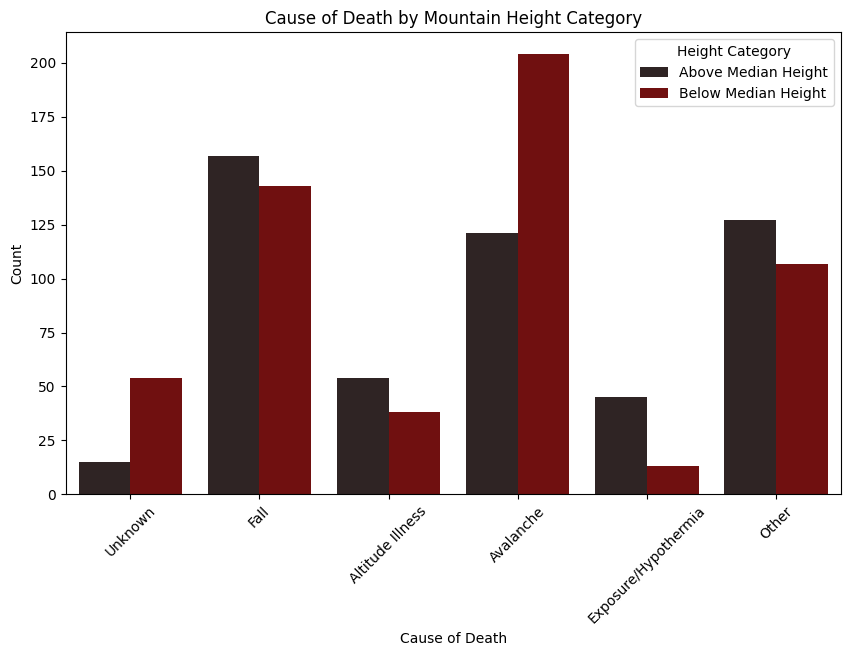

In [3]:
# Clean height and categorize mountains
df_mtn_death['Height_clean'] = df_mtn_death['Height(rounded)[dp 2]'].str.replace(',', '').astype(int)

median_height = df_mtn_death['Height_clean'].median()

df_mtn_death['Height Category'] = df_mtn_death['Height_clean'].apply(
    lambda x: 'Above Median Height' if x > median_height else 'Below Median Height'
)

# Function to simplify the cause of death
def simplify_cause(cause):
    cause = str(cause).lower()

    if "fall" in cause or "slip" in cause:
        return "Fall"
    if "avalanche" in cause:
        return "Avalanche"
    if ("exposure" in cause or "frostbite" in cause 
        or "hypothermia" in cause or "froze" in cause):
        return "Exposure/Hypothermia"
    if ("altitude" in cause or "ams" in cause 
        or "cerebral" in cause or "pulmonary" in cause):
        return "Altitude Illness"
    if "unknown" in cause or cause.strip() == "":
        return "Unknown"
    return "Other"

# Apply the function
df_mtn_death['Cause_simple'] = df_mtn_death['Cause of death'].apply(simplify_cause)

# Plot using the simplified cause categories
plt.figure(figsize=(10,6))
sns.countplot(data=df_mtn_death, x='Cause_simple', hue='Height Category', color = 'maroon')
plt.xticks(rotation=45)
plt.title('Cause of Death by Mountain Height Category')
plt.xlabel('Cause of Death')
plt.ylabel('Count')
plt.show()

# Linear Model

Now we are going to make a linear model to determine whether height of the mountain correlates with how likely climbers are to die on it. This doesn't necessarily account for how many people actually visit the mountain each year which is a limitation on these regression results.

In [4]:
# Linear model
xs = death_counts['Height']        
ys = death_counts['Death Count']  

# Add a constant term to the model
xs = sm.add_constant( xs )

# Fitting the model
model = sm.OLS( ys, xs ).fit()
model.summary()

/root/venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Death Count   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     8.163
Date:                Wed, 03 Dec 2025   Prob (F-statistic):             0.0144
Time:                        01:53:57   Log-Likelihood:                -76.537
No. Observations:                  14   AIC:                             157.1
Df Residuals:                      12   BIC:                             158.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1437.2377    530.240     -2.711      0.019   -2592.532    -281.943
Height         0.1828      0.064      2.857      0.014       0.043       0.322
==============================================================================
Omnibus:                        5.433   Durbin-Watson:                   0.972
Prob(Omnibus):                  0.066   Jarque-Bera (JB):                2.394
Skew:                           0.833   Prob(JB):                        0.302
Kurtosis:                       4.152   Cond. No.                     2.66e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.66e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Very interestingly, mountain height DOES correlate with how likely climbers are to die on the mountain. The coefficient of .1828 means that for every additional meter on the mountain, we can expect .1828 additional deaths. The P Value is less than .05 which means that at a 95% confidence level, we can say that the height of a mountain does correlate with the amount of climber deaths.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2429a37f-7420-4c06-9197-181ebcfdff46' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>